In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def make_censored_oh(Y, C, K):
    """
    Helper function that zeros out Y (after it has been digitized) based on whether or not
    the patient has been censored at that particular time point. 
    """
    Yr,Cr = Y.ravel(), C.ravel()
    oh    = np.zeros((Y.shape[0], K))
    for k in range(Y.shape[0]):
        oh[k, Yr[k]]= 1.
    return oh
    
def digitize_outcomes(Y, Yvalid, Ytest, Ymax, K, method='quantiles'):
    """
    Helper function that digitizes outcomes, which means it converts a single real number
    corresponding to date of death (for example) into a sequential vector that bins intermediate
    values.
    """
    if method=='quantiles':
        K_m_2     = K-1 # correct for bin edges
        probs     = np.arange(K_m_2+1)/float(K_m_2)
        bin_edges = stats.mstats.mquantiles(Y, probs)#[0, 2./6, 4./6, 1])
        bin_edges = bin_edges.tolist()
        bin_edges+= [Ymax]
        bin_edges = bin_edges
    elif method=='uniform':
        bin_edges = np.linspace(0, Ymax, K+1)
        bin_edges = bin_edges.tolist()
    else:
        raise ValueError('bad setting for method')
    predict = []
    for k in range(len(bin_edges)-1):
        predict.append((bin_edges[k]+bin_edges[k+1])/2.)
    predict = np.array(predict)
    
    Ytr  = np.digitize(Y.astype(float).ravel(), bin_edges)-1
    Yva  = np.digitize(Yvalid.astype(float).ravel(), bin_edges)-1
    Yte  = np.digitize(Ytest.astype(float).ravel(), bin_edges)-1
    print (Ytr.max()+1, Yva.max()+1, Yte.max()+1)
    assert predict.shape[0]==K,'Expecting K categories'
    return Ytr, Yva, Yte, predict

def load_mmrf_quick(fold_span = range(5), fval=None):
    """
    Helper function to load in data tensors from pkl files.
    
    Args: 
        fold_span: list of folds that we wish to select 
        fval: path to cleaned output files
    Returns: 
        dset_rest: returns data dictionary with folds and corresponding train, test, and validation
        sets.
    """
#     dir_path = os.path.dirname(os.path.realpath(__file__))
#     fval     = os.path.join(dir_path, 'output/cleaned_mm_fold'+suffix+'.pkl')
    print( 'loading from:', fval)
    dset_rest = {}
    for foldnum in fold_span:
        fn = fval.replace('_fold',str(foldnum))
        with open(fn, 'rb') as f:
            dset = pickle.load(f)
        dset_rest[foldnum] = dset[foldnum]
    return dset_rest

def load_mmrf(fold_span = range(5), data_dir=None, digitize_K = 0, digitize_method = 'uniform', \
              subsample = False, add_syn_marker=False, restrict_markers=[], \
              window='all', data_aug=False, ablation=False, feats=[]):
    """
    Main function that loads the tensors from the stored .pkl files (which are generated by 
    running python build_mmrf_dataset.py) and returns the dataset. 
    
    Args: 
        fold_span: list of folds that we wish to select 
        suffix: string that might appear in .pkl file names (e.g. _2mos), used to define path to 
        pickle files 
        digitize_K: int that determines to what extent to "digitize" outcomes into bins 
        digitize_method: method to digitize (either 'uniform' or 'quantiles')
        subsample: bool for whether or not to subsample training set 
        add_syn_marker: bool for whether or not to include a synthetic marker that is constructed 
        from observed lab values 
        restric_markers: bool for whether or not to restrict markers to serum M protein and the 
        synthetic marker
        window: string that determines how masks are going to be constructed (e.g. only look 
        at first and second line therapies for each patient). can be "all", "first_second", 
        or "second".      
    Returns: 
        new_dset: returns data dictionary with folds and corresponding train, test, and validation
        sets.
    """
    new_dset = load_mmrf_quick(fold_span = fold_span, fval=data_dir)
    
    # Make sure we only see data up to maxT
    for fold in fold_span:
        for tvt in ['train', 'valid', 'test']:
            M      = new_dset[fold][tvt]['m']
            m_t    = ((np.flip(np.cumsum(np.flip(M.sum(-1), (1,)), 1), (1,))>1.)*1)
            maxT   = m_t.sum(-1).max()
            new_dset[fold][tvt]['x'] = new_dset[fold][tvt]['x'][:,:maxT,:]
            new_dset[fold][tvt]['a'] = new_dset[fold][tvt]['a'][:,:maxT,:]
            new_dset[fold][tvt]['m'] = new_dset[fold][tvt]['m'][:,:maxT,:]
            new_dset[fold][tvt]['m_a'] = new_dset[fold][tvt]['m_a'][:,:maxT,:]
    
    if subsample: 
        # Transfer data from train to test set
        dir_path = os.path.dirname(os.path.realpath(__file__))
        fval     = os.path.join(dir_path, 'samples.pkl')
        if os.path.exists(fval):
            with open(fval,'rb') as f:
                sample_idx = pickle.load(f)
        else:
            np.random.seed(0)
            sample_idx = {}
            for fold in fold_span:
                N   = new_dset[fold]['train']['x'].shape[0]
                Ns  = int(N*0.15)
                idxshuf = np.random.permutation(N)
                sample_idx[fold] = (idxshuf[:Ns], idxshuf[Ns:])
            with open(fval,'wb') as f:
                pickle.dump(sample_idx, f)
        for fold in fold_span:
            keep, move = sample_idx[fold]
            for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
                new_dset[fold]['test'][kk] = np.concatenate([new_dset[fold]['test'][kk], new_dset[fold]['train'][kk][move]], axis=0)
                new_dset[fold]['train'][kk]= new_dset[fold]['train'][kk][keep]
                
    if digitize_K>0:
        for fold in fold_span:
            Ytrain, Yvalid, Ytest = new_dset[fold]['train']['ys_seq'][:,0].ravel(), new_dset[fold]['valid']['ys_seq'][:,0].ravel(), new_dset[fold]['test']['ys_seq'][:,0].ravel()
            Ymax  = np.max([Ytrain.max(), Yvalid.max(), Ytest.max()])+0.1
            print ('Digitizing outcomes ymax:',Ymax)
            ytrain_bin, yvalid_bin, ytest_bin, predictions = digitize_outcomes(Ytrain, Yvalid, Ytest, Ymax, digitize_K, method=digitize_method)
            new_dset[fold]['train']['digitized_y'] = make_censored_oh(ytrain_bin, new_dset[fold]['train']['ce'].ravel(), digitize_K)
            new_dset[fold]['valid']['digitized_y'] = make_censored_oh(yvalid_bin, new_dset[fold]['valid']['ce'].ravel(), digitize_K)
            new_dset[fold]['test']['digitized_y']  = make_censored_oh(ytest_bin,  new_dset[fold]['test']['ce'].ravel(), digitize_K)
            new_dset[fold]['train']['prediction'] = predictions
            new_dset[fold]['valid']['prediction'] = predictions
            new_dset[fold]['test']['prediction']  = predictions
    for fold in fold_span:
        for k in ['train','valid','test']:
            m    = (new_dset[fold][k]['m_a'].sum(-1)>0.)*1.
            mask = (m[:,::-1].cumsum(1)[:,::-1]>0)*1.
            lot  = new_dset[fold][k]['a'][...,-1]
            lot[:,0]    = 1.
            lot[lot==0] = np.nan
            df = pd.DataFrame(lot)
            df.fillna(method='ffill', axis=1, inplace=True) # forward fill
            lot = df.values
            lot = lot*mask
            lot[lot>=3] = 3.
            lot_oh      = np.zeros(lot.shape+(4,))
            for i in range(lot.shape[0]):
                for j in range(lot.shape[1]):
                    lot_oh[i,j,lot[i,j].astype(int)] = 1
            lot_oh      = lot_oh[...,1:]
            time_val    = np.ones_like(lot_oh[:,:,[-1]])
            time_val    = np.cumsum(time_val, 1)*0.1
            time_val    = (lot_oh.cumsum(1)*lot_oh*0.1).sum(-1,keepdims=True)
            new_dset[fold][k]['a'] = np.concatenate([time_val, new_dset[fold][k]['a'][...,:-1], lot_oh], -1)
            new_dset[fold][k]['feature_names_a'] = np.array(['local_clock']+new_dset[fold][k]['feature_names_a'].tolist()[:-1]+['line1','line2','line3plus'])
            
            if add_syn_marker: # synthetic marker is sum of two major Igs based on myeloma type
                x    = new_dset[fold][k]['x']
                m    = new_dset[fold][k]['m']
                b    = new_dset[fold][k]['b']
                b_names = new_dset[fold][k]['feature_names'].tolist()
                x_names = new_dset[fold][k]['feature_names_x'].tolist()
                new_x   = np.zeros((x.shape[0],x.shape[1],x.shape[2]+1))
                new_m   = np.ones((m.shape[0],m.shape[1],m.shape[2]+1))
                for i in range(x.shape[0]): 
                    tseq = np.zeros((x.shape[1],)) 
                    mhseq = np.ones((x.shape[1],)); mlseq = np.ones((x.shape[1],))
                    if b[i,b_names.index('igg_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_igg')]
                        mhseq = m[i,:,x_names.index('serum_igg')]
                    elif b[i,b_names.index('iga_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_iga')]
                        mhseq = m[i,:,x_names.index('serum_iga')]
                    elif b[i,b_names.index('igm_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_igm')]
                        mhseq = m[i,:,x_names.index('serum_igm')]
                    
                    if b[i,b_names.index('kappa_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_kappa')]
                        mlseq = m[i,:,x_names.index('serum_kappa')]
                    elif b[i,b_names.index('lambda_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_lambda')] 
                        mlseq = m[i,:,x_names.index('serum_lambda')]
        
                    tseq = tseq[:,np.newaxis]
                    new_x[i] = np.concatenate((new_dset[fold][k]['x'][i,:,:], tseq), axis=-1)
                    mseq     = np.ones((x.shape[1],1)) # change this line to make sure missingness pattern is correct (only 0 if both are missing)
#                     mseq = (mhseq.astype(int) | mlseq.astype(int)).astype(float)[:,np.newaxis]
                    new_m[i] = np.concatenate((new_dset[fold][k]['m'][i,:,:], mseq), axis=-1)
                new_dset[fold][k]['x'] = new_x; new_dset[fold][k]['m'] = new_m
                new_dset[fold][k]['feature_names_x'] = np.array(x_names + ['syn_marker'])
                print(f'adding synthetic marker in fold {fold}, set {k}...')
                print(f"new shape of X: {new_dset[fold][k]['x'].shape}")
                print(f"new shape of M: {new_dset[fold][k]['m'].shape}")
    
    if len(restrict_markers) != 0: 
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                x_names = new_dset[fold][k]['feature_names_x'].tolist()
                fs = []; ms = []
                for name in restrict_markers: 
                    f = new_dset[fold][k]['x'][...,x_names.index(name)][:,:,np.newaxis]
                    m = new_dset[fold][k]['m'][...,x_names.index(name)][:,:,np.newaxis]
                    fs.append(f); ms.append(m)
                new_dset[fold][k]['x'] = np.concatenate(tuple(fs),axis=-1)
                new_dset[fold][k]['m'] = np.concatenate(tuple(ms),axis=-1)
                new_dset[fold][k]['feature_names_x'] = np.array(restrict_markers)
                print(f'restricting longitudinal markers in fold {fold}, set {k}...')
                print(f"new shape of X: {new_dset[fold][k]['x'].shape}")
                print(f"new shape of M: {new_dset[fold][k]['m'].shape}")
    
    if window == 'first_second':
        d = set()
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                new_m = np.copy(new_dset[fold][k]['m'])
                a = new_dset[fold][k]['a']
                for pt in range(new_m.shape[0]): 
                    sec_idxs= np.where(a[pt,:,-2] == 1.)[0]
                    if len(sec_idxs) == 0: 
                        d.add(new_dset[fold][k]['pids'][pt])
                        # print(a[pt,:,:])
                        sec_end = np.min([np.max(np.where(a[pt,:,-3] == 1.)[0])+3,new_m.shape[1]])
                    else: 
                        sec_end = np.min([np.max(np.where(a[pt,:,-2] == 1.)[0])+3,new_m.shape[1]])
                    new_m[pt,sec_end:,:] = 0.
                new_dset[fold][k]['m'] = new_m
        #print(d)
    elif window == 'second':
        pass # implement mask alteration or altering dataset for restricting line of therapy
    
    if data_aug: 
        for fold in fold_span:
            augment_data(new_dset[fold], digitize_K=digitize_K)
    
    if ablation:
        ablate_idxs = {
            'none': (0,0),
            'none_trt': (0,2),
            'all': (0,new_dset[fold_span[0]]['train']['b'].shape[-1]), 
            'demog': (1,3),
            'iss': (0,4),
            'pc': (0,9),
            'hc': (0,10),
            'igg': (0,13), 
            'lc': (0,2),
            'comb_trts': (0,7),
            'asct': (0,8),
            'bor': (0,2),
            'car': (0,2), 
            'cyc': (0,3),
            'dex': (0,4),
            'len': (0,5),
            'lines': (0,new_dset[fold_span[0]]['train']['a'].shape[-1])
        }
        assert len(feats) != 0, 'Need to pass in the ablation params in feats argument'
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                include_baseline, include_treatment = feats[0], feats[1]
                bsidx, beidx = ablate_idxs[include_baseline]
                tsidx, teidx = ablate_idxs[include_treatment]
                
                new_dset[fold][k]['b'] = new_dset[fold][k]['b'][:,bsidx:beidx+1]
                new_dset[fold][k]['a'] = new_dset[fold][k]['a'][...,tsidx:teidx+1]
                if include_treatment == 'none_trt': 
                    new_dset[fold][k]['a'][...] = 0.
                elif include_treatment == 'lc': 
                    new_dset[fold][k]['a'][:,:,1:] = 0.
                elif include_treatment == 'bor': 
                    new_dset[fold][k]['a'][:,:,2] = 0.
                new_dset[fold][k]['feature_names'] = new_dset[fold][k]['feature_names'][bsidx:beidx+1]
                new_dset[fold][k]['feature_names_a'] = new_dset[fold][k]['feature_names_a'][tsidx:teidx+1]
                
    return new_dset

def augment_data(dset_fold, mult=25, digitize_K=0): 
    B = dset_fold['train']['b']; X = dset_fold['train']['x']
    M = dset_fold['train']['m']; CE= dset_fold['train']['ce']
    A = dset_fold['train']['a']; Y = dset_fold['train']['ys_seq']
    
    nsamples = mult*B.shape[0]
    if digitize_K > 0: 
        Ydig = dset_fold['train']['digitized_y']
        Ydigs = np.zeros((nsamples,Ydig.shape[1]))
        
    Bs = np.zeros((nsamples,B.shape[1]))
    Xs = np.zeros((nsamples,X.shape[1],X.shape[2]))
    As = np.zeros((nsamples,A.shape[1],A.shape[2]))
    Ms = np.zeros((nsamples,M.shape[1],M.shape[2]))
    if len(Y.shape) == 1: 
        Ys = np.zeros((nsamples,))
    else: 
        Ys = np.zeros((nsamples,Y.shape[1]))
    CEs = np.zeros((nsamples,CE.shape[1]))
    
    for i in range(mult): 
        As[i*A.shape[0]:(i+1)*A.shape[0]] = A
        Bs[i*B.shape[0]:(i+1)*B.shape[0]] = B
        Ms[i*M.shape[0]:(i+1)*M.shape[0]] = M
        Ys[i*Y.shape[0]:(i+1)*Y.shape[0]] = Y
        if digitize_K > 0: 
            Ydigs[i*Ydig.shape[0]:(i+1)*Ydig.shape[0]]= Ydig
        CEs[i*CE.shape[0]:(i+1)*CE.shape[0]] = CE
        
        p = np.random.uniform(0,1)
        if i == 0: 
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X
        elif p <= 0.5: 
            shift_factor = np.random.uniform(-4,4,size=X.shape[0])[:,None,None]
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X+shift_factor            
        else: 
            scale_factor = np.random.uniform(1,3,size=X.shape[0])[:,None,None]
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X*scale_factor
    
    dset_fold['train']['b'] = Bs; dset_fold['train']['x'] = Xs 
    dset_fold['train']['m'] = Ms; dset_fold['train']['ce'] = CEs
    dset_fold['train']['a'] = As; dset_fold['train']['ys_seq']= Ys
    
    if digitize_K > 0: 
        dset_fold['train']['digitized_y'] = Ydigs        

def get_te_matrix(): 
    ''' 
        5x16 matrix that contains direction of treatment effect on subset of lab features. 
        - 'Bor': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: 0, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        (http://chemocare.com/chemotherapy/drug-info/bortezomib.aspx, 
        https://www.ncbi.nlm.nih.gov/pubmed/20061695 [renal], 
        https://www.nature.com/articles/s41598-017-13486-x [renal], 
        https://clinicaltrials.gov/ct2/show/NCT00972959 [calcium])
        
        - 'Car': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: +1, Hb:-1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        (https://www.rxlist.com/kyprolis-side-effects-drug-center.htm [side effects])
        
        - 'Cyc': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: 0, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        [https://www.rxlist.com/cytoxan-side-effects-drug-center.htm]
        
        - 'Dex': PMN: -1, alb: 0, BUN: 0, Ca: -1, Crt: 0, Glc: +1, Hb: +1, Kappa: 0, 
        M-prot: 0, Plt: +1, TotProt: 0, WBC: -1, IgA: 0, IgG: 0, IgM: 0, Lambda: 0 
        [https://dm5migu4zj3pb.cloudfront.net/manuscripts/108000/108231/JCI75108231.pdf], 
        
        - 'Len': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: -1, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        [https://www.revlimid.com/mm-patient/about-revlimid/what-are-the-possible-side-effects/#common, 
        https://themmrf.org/multiple-myeloma/treatment-options/standard-treatments/revlimid/, 
        https://www.webmd.com/drugs/2/drug-94831/revlimid-oral/details/list-sideeffects]
        
        order of columns: array(['cbc_abs_neut', 'chem_albumin', 'chem_bun', 'chem_calcium',
           'chem_creatinine', 'chem_glucose', 'cbc_hemoglobin', 'serum_kappa',
           'serum_m_protein', 'cbc_platelet', 'chem_totprot', 'cbc_wbc',
           'serum_iga', 'serum_igg', 'serum_igm', 'serum_lambda'],
           dtype='<U15')
        order of rows: 'Bor', 'Car', 'Cyc', 'Dex', 'Len'
    '''
    te_matrix = np.array([[-1, 0, 1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 0, -1, 0, 1, 1, 0, 0, 1, 0, -1, 0, 0, 0, 0], 
                          [-1, 0, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])
    
    return te_matrix

dset = load_mmrf(data_dir="/content/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl")

# lab values - x
# outcome - y
# baseline - b
# treatment - a

# features matrix
X_train = dict()
y_train = dict()

X_valid = dict()
y_valid = dict()

X_test = dict()
y_test = dict()

def univariate_X_y(data_dict, p1=0, p2=0):
  X = dict()
  X["names_lab"] = data_dict["feature_names_x"]
  X["lab_feat"] = np.array([data_dict["x"][..., i][:, p1:-1] for i in range(data_dict["x"].shape[2])])

  X["names_baseline"] = data_dict["feature_names"]
  X["baseline_feat"] = data_dict["b"]

  X["names_trt"] = data_dict["feature_names_a"]
  X["trt_feat"] = np.array([data_dict["a"][..., i][:, p2:-1] for i in range(data_dict["a"].shape[2])])

  y = np.array([data_dict["x"][..., i][:, -1] for i in range(data_dict["x"].shape[2])])
  return X, y


for i in range(len(dset)):
  X_train[i], y_train[i] = univariate_X_y(dset[i]["train"])
  X_valid[i], y_valid[i] = univariate_X_y(dset[i]["valid"])
  X_test[i], y_test[i] = univariate_X_y(dset[i]["test"])




# arima
class arimaxb:

  def __init__(self, p, q, X, y, fold, lab):
    self.p=p
    self.q=q
    self.X_train= X
    self.y_train = y
    self.fold = fold
    self.lab = lab
  
  def prepare(self, X_train, y_train, fold, lab, diff=False, includeY=True):
    shape = X_train[fold]['lab_feat'][lab].shape
    # lab
    if diff:
      X_train_lab = np.zeros((0, shape[1]-1))
      for i in range(0, shape[0]):
        X_train_lab = np.concatenate((X_train_lab, np.diff(X_train[fold]['lab_feat'][lab][i]).reshape(1,-1)))
    else:
      X_train_lab=X_train[fold]['lab_feat'][lab]

    # baseline
    X_train_base = X_train[fold]['baseline_feat']

    #trt
    if diff:
      X_train_trt = np.zeros((0, shape[0], shape[1]-1))
      for i in range(1,9):
        trt= np.zeros((0, shape[1]-1))
        for j in range(0, shape[0]):
          trt = np.concatenate((trt, np.diff(X_train[fold]['trt_feat'][i,j,:]).reshape(1,-1)))
        X_train_trt = np.concatenate((X_train_trt, trt.reshape(1,shape[0],-1)))
    else:
      X_train_trt = X_train[fold]['trt_feat'][1:]

    #y
    if includeY:
      y_train_diff = y_train[fold][lab]
    else:
      y_train_diff = np.zeros(shape[0])
    return X_train_base, X_train_lab, X_train_trt, y_train_diff

  def parseAR(self, p, Xt, yt, includeY):
    X = Xt.reshape(1,-1)
    if includeY:
      y=np.zeros((1))
      y[0]=yt
      X=np.concatenate((Xt,y)).reshape(1,-1)
    days=X.shape[1]
    # print(X)
    temp=X[0,:p]
    y=np.array(X[0,p])
    for i in range(1,days-p):
      # print(X[0,i+p])
      temp=np.vstack([temp,X[0,i:i+p]])
      y=np.append(y,X[0,i+p])
    # print(temp)
    # print(y)
    return temp, y
  
  def AR(self, p, X_train_base, X_train_lab, X_train_trt, y_train, fold, lab):
    size = X_train_base.shape[0]

    X_temp= X_train_base

    X=np.zeros((0,X_temp.shape[1]+p*9))
    y=np.array(0)
    # print(X.shape)
    #add ar for lab values
    for i in range(0, X_temp.shape[0]):
      X_lab, y_lab = self.parseAR(p, X_train_lab[i,:], y_train[i], True)
      for j in range(0,8):
        X_trt, y_trt = self.parseAR(p, X_train_trt[j,i,:], np.array(0), True)
        X_lab=np.concatenate((X_lab, X_trt), axis=1)
      # print(X_lab.shape)
      # print(y_lab.shape)
      X_lab= np.concatenate((np.tile(X_temp[i],(X_lab.shape[0], 1)), X_lab), axis=1)
      # print(X_lab.shape)
      X=np.vstack([X,X_lab])
      y=np.append(y,y_lab)
    
    y=y[1:]
    # print(X.shape)
    # print(y.shape)

    lr = LinearRegression()
    lr.fit(X,y)

    return lr.coef_, lr.intercept_

  def predict_AR_single(self, X_train_base, X_train_lab, X_train_trt, p, fold, lab, person):
    days = X_train_lab.shape[1]
    X_pred=np.zeros((days-p+1,0))
    X_pred= np.concatenate((X_pred, np.tile(X_train_base[person],(days-p+1, 1))),axis=1)

    #add ar for lab values
    X_lab = np.zeros((0,p))
    for i in range(0,days-p+1):
      # print([i, i+p])
      X_lab = np.concatenate((X_lab,X_train_lab[person,i:i+p].reshape(-1,p)), axis=0)
      
    X_pred = np.concatenate((X_pred, X_lab), axis=1)
    # ar treatment
    for i in range(0,8):
      X_trt=np.zeros((0,p))
      for j in range(0,days-p+1):
        X_trt = np.concatenate((X_trt, X_train_trt[i,person, j:j+p].reshape(-1,p)), axis=0)
      X_pred=np.concatenate((X_pred, X_trt), axis=1)

    # print(X_pred.shape)
    y_pred=X_pred.dot(self.coef_ar.T) + self.intercept_ar

    return y_pred, X_pred

  def predictAR(self, X_base, X_lab, X_trt, p, fold, lab):
    size = X_base.shape[0]
    days = X_lab.shape[1]
    y_pred = np.zeros((0,days-p+1))
    for i in range(0, size):
      temp, _ = self.predict_AR_single(X_base, X_lab, X_trt, p, fold, lab, i)
      y_pred = np.concatenate((y_pred, temp.reshape(1,-1)))
    return y_pred

  def parseMA(self, q, X):
    ys=X.shape[0]
    temp=X[:q]
    y=np.array(X[q])
    for i in range(1,ys-q):
      # print(X[0,i+p])
      temp=np.vstack([temp,X[i:i+q]])
      y=np.append(y,X[i+q])
    # print(temp)
    # print(y)
    return temp, y

  def MA(self, q,res):
    size = res.shape[0]
    X= np.zeros((0,q))
    y=np.array(0)
    for i in range(0,size):
      Xt, yt=self.parseMA(q, res[i])
      X = np.concatenate((X, Xt.reshape(-1,q)))
      y=np.append(y,yt)
    y=y[1:]
    # print(X.shape)
    # print(y.shape)

    lr = LinearRegression()
    lr.fit(X,y)
    return lr.coef_, lr.intercept_, X, y

  def predict_MA_single(self, q, res, person):
    days = res.shape[1]
    X = np.zeros((0,q))
    for i in range(0,days-q):
      X = np.concatenate((X,res[person, i:i+q].reshape(1,-1)), axis=0)

    # print(X.shape)
    y_pred=X.dot(self.coef_ma.T) + self.intercept_ma
    return y_pred

  def predict_MA_last(self, q, res, coef, intercept):
    days = res.shape[1]
    X=res[:, days-q-1:days-1]
    y_pred=X.dot(self.coef_ma.T) + self.intercept_ma
    return y_pred

  def predict_MA(self, q, res, coef, intercept):
    size = res.shape[0]
    days = res.shape[1]
    y_pred = np.zeros((0,days-q))
    for i in range(0, size):
      temp = self.predict_MA_single(q, res, i)
      y_pred = np.concatenate((y_pred, temp.reshape(1,-1)))
    return y_pred

  def predict_single(self, X, p, q, fold, person, diff):
    fold = self.fold
    lab=self.lab
    X_base, X_lab, X_trt, _ = self.prepare(X, np.array(0), fold, lab, diff, False)
    y_ar, _ = self.predict_AR_single(X_base, X_lab, X_trt, p, fold, lab, person)
    days = X_lab.shape[1]
    y = X_lab[person, p:days]

    res = y-y_ar
    y_ma= self.predict_MA_single(q, res.reshape((1,-1)), 0)
    y_pred = y_ar[q:]
    y_pred += y_ma
    if diff:
      y_pred_act = y_pred+X_train[fold]['lab_feat'][lab,person,p+q-1:days-1]
    else:
      y_pred_act=y_pred
    return y_pred_act
  
  def predict_y(self, X, p, q, fold, lab):
    X_base, X_lab, X_trt, _ = self.prepare(X, np.array(0), fold, lab, False, False)
    y_ar = self.predictAR(X_base, X_lab, X_trt, p, fold, lab)
    # y_last = self.predict_ar_y(X_base, X_lab, X_trt, p, fold, lab)
    days = X_lab.shape[1]
    y = X_lab[:, p:]
    res = y-y_ar[:,:y_ar.shape[1]-1]
    # print(res.shape)
    days = res.shape[1]
    X=res[:, days-q:]
    y_pred=X.dot(self.coef_ma.T) + self.intercept_ma
    y_pred = y_ar[:,y_ar.shape[1]-1] + y_pred
    return y_pred.flatten()

  def predict(self, X, p, q, fold, lab):
    X_base, X_lab, X_trt, _ = self.prepare(X, self.y_train, fold, lab, False, False)
    y_ar = self.predictAR(X_base, X_lab, X_trt, p, fold, lab)
    days = X_lab.shape[1]
    y = X_lab[:, p:days]
    res = y-y_ar[:,:y_ar.shape[1]-1]
    # res = res[:, :res.shape[1]-1]

    y_ma= self.predict_MA(q, res, self.coef_ma, self.intercept_ma)
    y_pred = y_ar[:,q+1:] + y_ma
    return y_pred

  def predict_last(self, X, p, q, fold, lab):
    X_base, X_lab, X_trt, _ = self.prepare(X, np.array(0), fold, lab, False, False)
    y_ar = self.predictAR(X_base, X_lab, X_trt, p, fold, lab)
    days = X_lab.shape[1]
    y = X_lab[:, p:]
    res = y-y_ar
    # res = res[:, :res.shape[1]-1]
    # print(res.shape)

    y_ma= self.predict_MA_last(q, res, self.coef_ma, self.intercept_ma)
    y_pred = y_ar[:, y_ar.shape[1]-1] + y_ma
    return y_pred.flatten()

  def predict_ar_y(self, X_train_base, X_train_lab, X_train_trt, p, fold, lab):
    days = X_train_lab.shape[1]
    X_pred= X_train_base
    X_pred = np.concatenate((X_pred, X_train_lab[:, days-p:].reshape(-1,p)), axis=1)
    # print([days-p, days])
    # ar treatment
    for i in range(0,8):
      X_pred=np.concatenate((X_pred, X_train_trt[i,:, days-p:].reshape(-1,p)), axis=1)

    # print(X_pred.shape)
    y_pred=X_pred.dot(self.coef_ar.T) + self.intercept_ar
    return y_pred


  def fit(self, p, q, diff):
    X_train_base, X_train_lab, X_train_trt, y_train_diff = self.prepare(self.X_train, self.y_train, self.fold, self.lab, diff=diff)
    # print(X_train_base.shape)
    # print(X_train_lab.shape)
    # print(X_train_trt.shape)

    self.coef_ar, self.intercept_ar = self.AR(p,X_train_base, X_train_lab, X_train_trt, y_train_diff, self.fold, self.lab)
    y_pred = self.predictAR(X_train_base, X_train_lab, X_train_trt,p, self.fold, self.lab) 
    # print(y_pred.shape)
    y= X_train_lab[:,p:]
    res = y-y_pred[:, :y_pred.shape[1]-1]
    self.coef_ma, self.intercept_ma, res_x, res_y = self.MA(q, res)



def cv_last(lab):
  min_err = 10000
  bestp = 0
  bestq = 0
  all_val = np.zeros((0,3))

  for p in range(1,30):
    for q in range(1,34-p):
      rmse = np.zeros((5))
      for f in range(0,5):
        arima = arimaxb(p,q,X_train, y_train, f, lab)
        arima.fit(p, q, False)

        y_pred = arima.predict_last(X_valid, p, q, f, lab)
        y= X_valid[f]['lab_feat'][lab,:,34]
        err = np.sqrt(mean_squared_error(y, y_pred))
        rmse[f]=err
      mean = np.mean(rmse)
      all_val = np.vstack([all_val, np.array((p, q, mean))])
      # print("lab: "+str(lab)+" , p: "+ str(p)+ " , q: "+ str(q) + ", rmse: "+ str(mean))
      if mean<min_err:
        min_err = mean
        bestp= p
        bestq=q
  return bestp, bestq, min_err, all_val

def cv(lab):
  min_err = 10000
  bestp = 0
  bestq = 0
  all_val = np.zeros((0,3))

  for p in range(1,30):
    for q in range(1,34-p):
      rmse = np.zeros((5))
      for f in range(0,5):
        arima = arimaxb(p,q,X_train, y_train, f, lab)
        arima.fit(p, q, False)

        y_pred = arima.predict(X_valid, p, q, f, lab)
        y= X_valid[f]['lab_feat'][lab,:,p+q+1:]
        err = np.sqrt(mean_squared_error(y, y_pred))
        rmse[f]=err
      mean = np.mean(rmse)
      all_val = np.vstack([all_val, np.array((p, q, mean))])
      # print("lab: "+str(lab)+" , p: "+ str(p)+ " , q: "+ str(q) + ", rmse: "+ str(mean))
      if mean<min_err:
        min_err = mean
        bestp= p
        bestq=q
  return bestp, bestq, min_err, all_val



loading from: /content/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl


In [ ]:
def cv_y(lab):
  min_err = 10000
  bestp = 0
  bestq = 0
  all_val = np.zeros((0,3))

  for p in range(1,25):
    for q in range(1,31-p):
      rmse = np.zeros((5))
      for f in range(0,5):
        arima = arimaxb(p,q,X_train, y_train, f, lab)
        arima.fit(p, q, False)

        y_pred = arima.predict_y(X_valid, p, q, f, lab)
        y= y_valid[f][lab]
        err = np.sqrt(mean_squared_error(y, y_pred))
        rmse[f]=err
      mean = np.mean(rmse)
      all_val = np.vstack([all_val, np.array((p, q, mean))])
      # print("lab: "+str(lab)+" , p: "+ str(p)+ " , q: "+ str(q) + ", rmse: "+ str(mean))
      if mean<min_err:
        min_err = mean
        bestp= p
        bestq=q
  return bestp, bestq, min_err, all_val

In [ ]:
result=dict()
val = dict()
for i in range(1,2):
  p, q, rmse, v = cv_y(i)
  result[i]= [p, q, rmse]
  val[i]=v
  print([i, p, q, rmse])
  # [0, 6, 17, 1.0965768293812694]

[1, 6, 22, 0.9608730947851903]


In [ ]:
# lab y test
# p= [1,1,2,1,1,1,1,2,2,1,2,2,1,2,1,13]
# q= [30,29,28,29,29,30,29,26,31,28,29,29,30,28,26,20]

# p=[1,1,1,13,1,1,1,2,4,13,1]
# q=[27,26,30,17,28,30,29,24,29,12,29]

# p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
# q=[29,27,29,27,28,29,29,26,29,27,29,29,29,28,29,29]

# update
p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

# print(X_train[0]['lab_feat'].shape)

for lab in range(0, 16):
  arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
  arima.fit(p[lab], q[lab], False)
  y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
  y = y_test[0][lab]
  rmse = np.sqrt(mean_squared_error(y, y_pred))
  # llh = logLikelihood(y_pred, y)
  # print(llh)
  print(rmse)

1.1092787456535567
1.0836670276914206
1.0983623680211527
1.0792050637594781
1.0054472799608158
0.9304287752029179
1.0330667836297045
0.9153808050676476
1.2215424757572269
1.1019650229700677
1.2536031517317152
1.0785505347471562
1.108102623302123
0.980926859498508
1.1985876663965285
1.182144717621112


1.3486364401601099


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

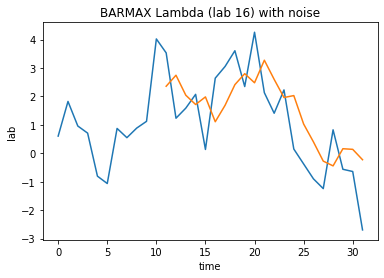

In [ ]:
lab=15
p=5
q=5
per=0
arima = arimaxb(p, q, X_train, y_train, 0, lab)
arima.fit(p, q, False)
y_pred = arima.predict(X_test, p, q, 0, lab)
y = X_test[0]['lab_feat'][lab,per,p+q+1:]
y = np.append(y,y_test[0][lab,per])
# print(y.shape)
# print( y_pred[per].shape)
# y=np.delete(y,142,0)
# y=np.delete(y,54,0)
# y_pred = np.delete(y_pred,142, 0)
# y_pred=np.delete(y_pred,54,0)
rmse = np.sqrt(mean_squared_error(y, y_pred[per]))
print(rmse)
plt.plot(np.arange(0,32), X_test[0]['lab_feat'][lab,per,:])
plt.plot(np.arange(p+q+1,32), y_pred[per,:y_pred.shape[1]-1])
plt.title("BARMAX Lambda (lab 16) with noise")
plt.xlabel("time")
plt.ylabel("lab")
plt.savefig("barmax-16-noise-0.png")
files.download("barmax-16-noise-0.png") 

Index(['iss', 'age', 'gender', 'ecog', 'line1sct', 'serum_beta2_microglobulin',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
       'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46',
       'PC47', 'PC48', 'PC49', 'PC50', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')


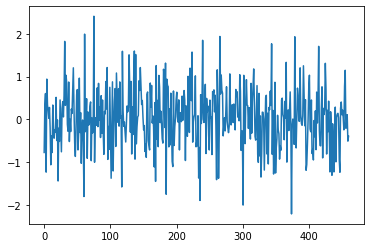

In [ ]:
#patient 238
print(X_train[0]['names_baseline'])
# print(X_train[0]['baseline_feat'][238])
# print(X_train[0]['baseline_feat'][0])
plt.plot(np.arange(0,460), X_train[0]['baseline_feat'][:,26])

In [ ]:
e=np.zeros((460))
y=X_train[0]['baseline_feat'][238]
for i in range(0,460):
  err =mean_squared_error(y, X_train[0]['baseline_feat'][i])
  e[i]=err
e=np.argsort(e)
print(e[:5])

[238  69 147 368  57]


In [ ]:
# np.set_printoptions(suppress=True)
# print(arima.coef_ar.shape)
# co = np.copy(arima.coef_ar)
# print(np.argsort(co))
print(X_test[0]['names_lab'])

['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']


In [ ]:
# create 238 patient with 9 trt
X=dict()
X[0]=dict()
X[0]['baseline_feat']=X_test[0]['baseline_feat'][238].reshape(1,-1)
X[0]['trt_feat']=X_test[0]['trt_feat'][:,69,:].reshape(9,1,-1)
X[0]['lab_feat']=X_test[0]['lab_feat'][:,238,:].reshape(16,1,-1)
# print(X)
y_patp = arima.predict_y(X, p[lab], q[lab], 0, 15)
print(y_patp)

[0.30647527]


0.34035595595682744


(-4.5, 5.5)

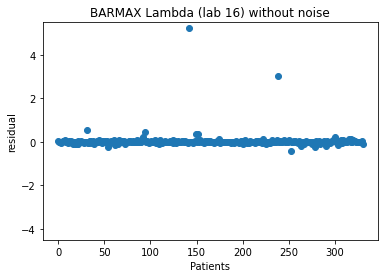

In [ ]:
# p= [1,1,2,1,1,1,1,2,2,1,2,2,1,2,1,1]
# q= [30,29,28,29,29,30,29,26,31,28,29,29,30,28,26,29]

p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
# p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
# q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=15
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
# y=np.delete(y,142,0)
# y=np.delete(y,54,0)
# y_pred = np.delete(y_pred,142, 0)
# y_pred=np.delete(y_pred,54,0)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.plot(np.arange(0,y.shape[0]), y-y_pred, 'o')
plt.title("BARMAX Lambda (lab 16) without noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-4.5, 5.5)


In [ ]:
from google.colab import files

####lab 8 kappa


0.9052965517098072


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

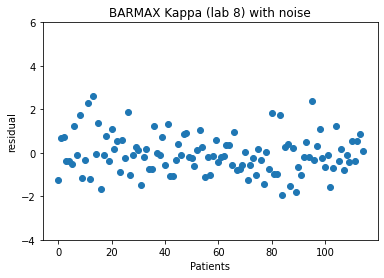

In [ ]:
# p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
# q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=7
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX Kappa (lab 8) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-4, 6)
plt.savefig("barmax-8-noise.png")
files.download("barmax-8-noise.png") 

0.10841616645396948


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

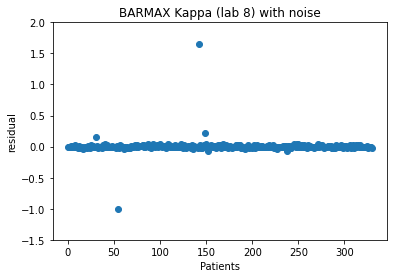

In [ ]:
p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# # update
# p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
# q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=7
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX Kappa (lab 8) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-1.5, 2)
plt.savefig("barmax-8-no-noise.png")
files.download("barmax-8-no-noise.png") 

####lab 13 iga


1.0985627425717914


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

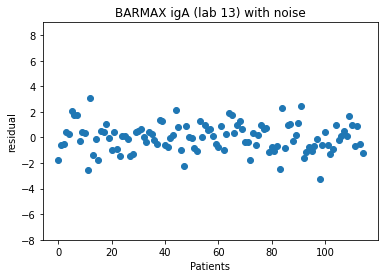

In [ ]:
# p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
# q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=12
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX igA (lab 13) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-8,9)
plt.savefig("barmax-13-noise.png")
files.download("barmax-13-noise.png") 

0.22377796513151887


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

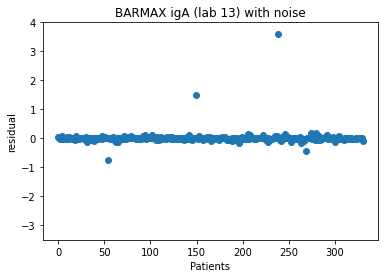

In [ ]:
p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# # update
# p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
# q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=12
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX igA (lab 13) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-3.5,4)
plt.savefig("barmax-13-no-noise.png")
files.download("barmax-13-no-noise.png") 

####lab 14 igg


0.9821247775802455


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

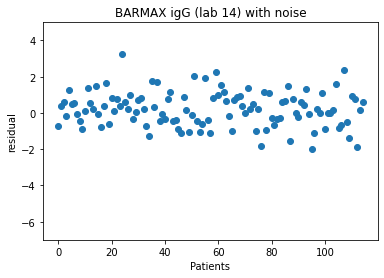

In [ ]:
# p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
# q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=13
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX igG (lab 14) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-7,5)
plt.savefig("barmax-14-noise.png")
files.download("barmax-14-noise.png") 

0.06366030134091562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

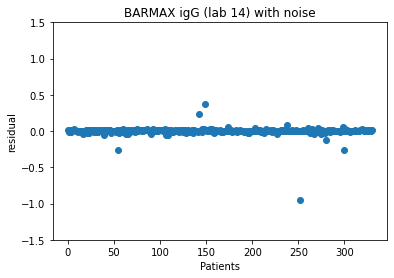

In [ ]:
p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
# p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
# q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=13
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX igG (lab 14) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-1.5,1.5)
plt.savefig("barmax-14-no-noise.png")
files.download("barmax-14-no-noise.png") 

####lab 16 lambda

1.1525916245025924


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

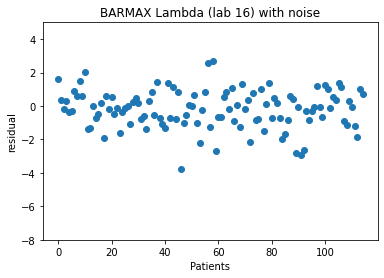

In [ ]:
# p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
# q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=15
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX Lambda (lab 16) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-8,5)
plt.savefig("barmax-16-noise.png")
files.download("barmax-16-noise.png") 

0.34035595595682744


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

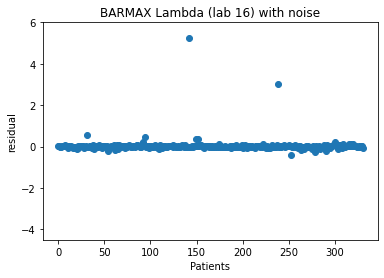

In [ ]:
p=[1,1,1,2,1,1,1,2,2,1,2,1,1,2,1,1]
q=[30,27,30,28,28,32,29,26,29,27,29,32,29,28,30,29]

# update
# p=[6,6,6,5,10,1,6,7,16,4,1,6,1,15,4,5]
# q=[17,22,20,17,4,19,21,21,13,24,20,5,26,12,18,21]

lab=15
arima = arimaxb(p[lab], q[lab], X_train, y_train, 0, lab)
arima.fit(p[lab], q[lab], False)
y_pred = arima.predict_y(X_test, p[lab], q[lab], 0, lab)
y = y_test[0][lab]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)
plt.scatter(np.arange(0,y.shape[0]), y-y_pred)
plt.title("BARMAX Lambda (lab 16) with noise")
plt.xlabel("Patients")
plt.ylabel("residual")
plt.ylim(-4.5,6)
plt.savefig("barmax-16-no-noise.png")
files.download("barmax-16-no-noise.png") 

(array([142, 238]),)
[-0.8269316454350923, 0.2277997356129734]
[4.41, 3.25]


Text(0, 0.5, 'lab')

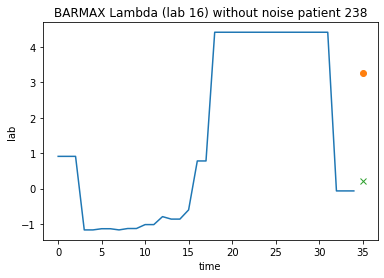

In [ ]:
# lab15
t = y-y_pred
print(np.where(t>2))
print([y_pred[142], y_pred[238]])
print([y[142], y[238]])
ppl =[142,238]
ypred=[-0.8269316454350923, 0.2277997356129734]
yy=[4.41, 3.25]
lab = 15
person=238
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, yy[1], marker='o')
plt.plot(35, ypred[1], marker='x')
plt.title("BARMAX Lambda (lab 16) without noise patient 238")
plt.xlabel("time")
plt.ylabel("lab")

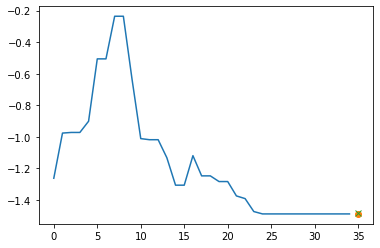

In [ ]:
# lab13
t = y-y_pred
# print(np.where(t<-0.5))
# print([y_pred[252]])
# print([y[252]])
ppl =[252]
ypred=[0.39592967216450115]
yy=[-0.55599993]
lab = 13
person=246
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y[246], marker='o')
plt.plot(35, y_pred[246], '--', marker='x')

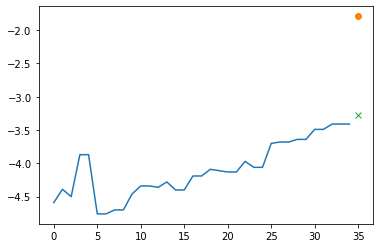

In [ ]:
# lab12
t = y-y_pred
# print(np.where(t>1))
# print([y_pred[149], y_pred[238]])
# print([y[149], y[238]])

ppl =[149,238]
ypred=[-3.26954446103665, -3.482436608319719]
yy=[-1.7899997, 0.03000021]
lab = 12
person=0
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,ppl[person], :])
plt.plot(35, yy[person], marker='o')
plt.plot(35, ypred[person], '--', marker='x')

(array([54]),)
[-0.058418928860172595, 0.933900203034153]
[1.5887499, -0.09125]


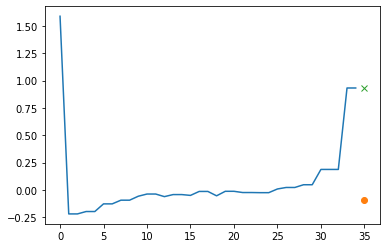

In [ ]:
# lab7
t = y-y_pred
# print(np.where(t<-0.6))
# print(np.where(0.5))
# print([y_pred[142], y_pred[54]])
# print([y[142], y[54]])
ppl =[142,54]
ypred=[-0.058418928860172595, 0.933900203034153]
yy=[1.5887499, -0.09125]
lab = 7
person=1
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,ppl[person], :])
plt.plot(35, yy[person], marker='o')
plt.plot(35, ypred[person], '--', marker='x')

(array([238]),)


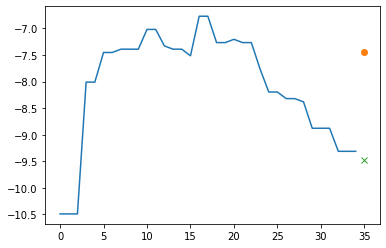

In [ ]:
# lab6
t = y-y_pred
print(np.where(t>1.5))
ppl =[238]
lab = 6
person=ppl[0]
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y_test[0][lab, person], marker='o')
plt.plot(35, y_pred[person], '--', marker='x')

(array([152]),)


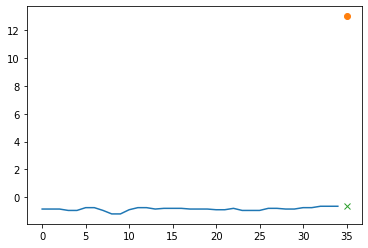

In [ ]:
# lab3
t = y-y_pred
print(np.where(t>2))
ppl =[152]
lab = 3
person=ppl[0]
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y_test[0][lab, person], marker='o')
plt.plot(35, y_pred[person], '--', marker='x')

In [ ]:
print(X_train[0]['names_lab'])

['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']


(array([280]),)
(array([152]),)


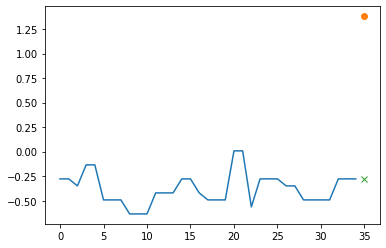

In [ ]:
# lab2
t = y-y_pred
print(np.where(t<-0.5))
print(np.where(t>1))
ppl =[280,152]
lab = 2
person=ppl[1]
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y_test[0][lab, person], marker='o')
plt.plot(35, y_pred[person], '--', marker='x')

(array([ 54, 149, 237]),)
(array([142, 238, 300]),)


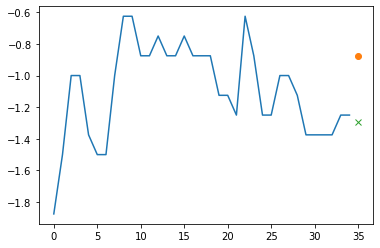

In [ ]:
# lab1
t = y-y_pred
print(np.where(t<-0.2))
print(np.where(t>0.2))
ppl =[54, 142, 149, 238, 237, 300]
lab = 1
person=ppl[1]
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y_test[0][lab, person], marker='o')
plt.plot(35, y_pred[person], '--', marker='x')

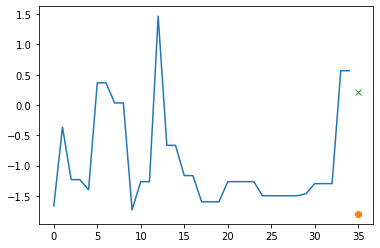

In [ ]:
person =300
lab = 0
plt.plot(np.arange(0,35), X_test[0]['lab_feat'][lab,person, :])
plt.plot(35, y_test[0][lab, person], marker='o')
plt.plot(35, y_pred[person], '--', marker='x')